In [1]:
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

from pyspark import SparkConf

#Functionality imports
from pyspark.sql import *
from pyspark.sql.types import *
import folium
from IPython.display import HTML
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics

sc = SparkSession.builder.getOrCreate()

#Configure to use 4 cores
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])
sc.stop()
sc = pyspark.SparkContext(conf=conf)

sqlContext = SQLContext(sc)

sqlContext.setConf('spark.sql.shuffle.partitions', '8')

df = sqlContext.sql('''select 'Groep 1' as hallo ''')
df.show()

+-------+
|  hallo|
+-------+
|Groep 1|
+-------+



In [3]:
MONTHS = ['01','02','03','04','05','06','07','08','09','10','11','12']

# Maand Stiptheid% Aantal_treinen_met_minder_dan_ 6min._vertraging Aantal_min_vertraging Stiptheid_na_neutralisatie
train_data = []
evolution_data = []

def make_train_dict(data):
    train_dict = {}
    train_lines = data.collect()
    train_lines.sort()
    for line in train_lines:
        line = line.replace('"', '')
        all_vals = line.split(';')
        train_dict[(all_vals[0])] = [all_vals[3], (all_vals[4]), (all_vals[5])]
    return train_dict

train_data = (sc.textFile('../Data Mining Project/nationale-stiptheid-per-maand.csv').filter(lambda l: 'maand' not in l))
s = make_train_dict(train_data)
train_data = sc.broadcast(s)
print(train_data.value)
print('---------')

#Code Kwartaal Sector Aantal-km
#Enkel effectieve data!
def make_evolution_dict(data):
    evolution_dict = {}
    evolution_lines = data
    evolution_lines.sort()
    for line in evolution_lines:
        all_vals = line.split(';')
        if(all_vals[3] == 'Effectief'):
            evolution_dict[(all_vals[0]) + ' - ' + (all_vals[1][8]) + ' - ' +(all_vals[2][0])] = [all_vals[0], all_vals[1], all_vals[2], all_vals[4]]
    return evolution_dict

datafile = open('../Data Mining Project/evolutie-van-treinkilometers.csv')
section = None
found   = []
match   = set(["Faction=Blahdiddly"])  # can be multiple items

for line in datafile:
    line = line.strip()
    found.append(line)

e = make_evolution_dict(found)
evolution_data = sc.broadcast(e)
print(evolution_data.value)

{'2016-01': ['89899.0', '212787', '95.9923225336'], '2016-02': ['92905.0', '203292', '95.16594446020001'], '2016-03': ['94993.0', '209805', '97.5642140053'], '2016-04': ['89996.0', '195684', '96.4848192092'], '2016-05': ['81611.0', '210082', '98.2279892433'], '2016-06': ['84004.0', '261317', '97.8359096314'], '2016-07': ['93071.0', '161023', '98.2277116013'], '2016-08': ['94666.0', '184347', '96.8372588931'], '2016-09': ['94621.0', '218103', '95.91235604879999'], '2016-10': ['90373.0', '286975', '95.085812357'], '2016-11': ['81913.0', '337994', '87.29115393080001'], '2016-12': ['95568.0', '229134', '93.4390872423'], '2017-01': ['97822.0', '206171', '93.1717224175'], '2017-02': ['88998.0', '224076', '92.5678851828'], '2017-03': ['100688.0', '238126', '93.2669060656'], '2017-04': ['92468.0', '165001', '95.484710475'], '2017-05': ['94896.0', '283128', '91.7464747624'], '2017-06': ['93292.0', '273664', '92.02903974249999'], '2017-07': ['94664.0', '171279', '94.6339515312'], '2017-08': ['97

In [4]:
from IPython.display import HTML

#Input form in jupyter notebook
form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
<p>Geef een jaar tussen 2016 en 2018</p>
Jaar: <input type="text" id='year' value="2018"/><br>
 <button onclick="set_salparvars()">Zoek</button> 
</div>
"""
#Called function from button onclick
javascript = """
<script type="text/Javascript">
    function set_salparvars(){
        var var_name1 = 'inp_year';
        var var_value1 = document.getElementById('year').value;
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        cell = IPython.notebook.get_cell(3);
        cell.execute();
        cell.focus_cell(3);
    }
</script>
"""
#Rendering the html
HTML(form + javascript)

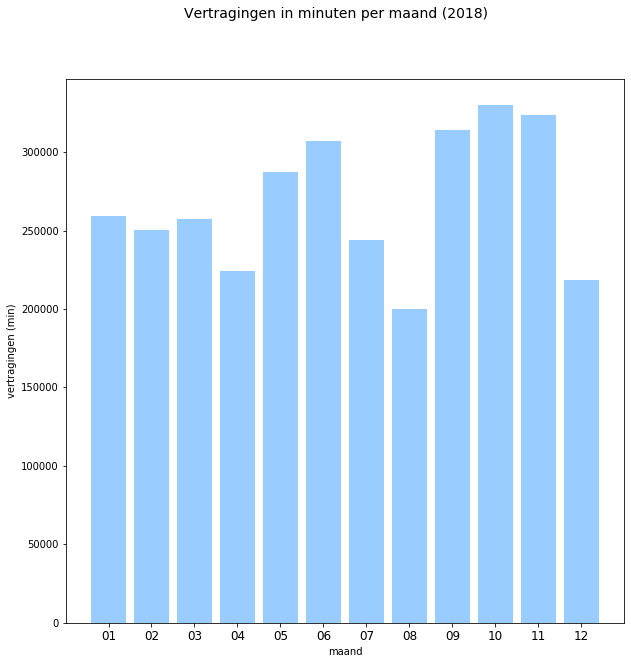

In [7]:
#check of dat dit automatisch kan worden uitgevoerd
%matplotlib inline
import matplotlib.pyplot as plt

x_axis = [i+1 for i in range(0,12)]
y_axis = []

try:
    inp_year = int(inp_year)  
    inp_year = str(inp_year)
    if int(inp_year) >=2016 and int(inp_year) <=2018:
        vals=[]
        for i in range(1,13):
            var = inp_year + '-' + str(i).zfill(2)
            y_axis.append(int(train_data.value[var][1]))
        fig1 = plt.figure(figsize=(10 , 10))
        fig1.suptitle('Vertragingen in minuten per maand (' + inp_year + ')', fontsize=14)
        ax = fig1.add_subplot(111)
        ax.set_xlabel('maand')
        ax.set_ylabel('vertragingen (min)')
        ax.bar(x_axis, y_axis, align='center', color='#99ccff')
        #Set the x axis tick labels
        plt.xticks(x_axis, MONTHS ,fontsize = 12)
        plt.show()
    else:
        print("geen gelidge waarde ingegeven, de waarde moet liggen tussen 2016 en 2018")
except ValueError:
         print("input is geen geldige waarde")

In [6]:
#totalen per jaar van de aantal minuten
YEARS = ['2016','2017','2018']
vals = []

for y in range(1,4):
    year = YEARS[y-1]
    var = 0
    for i in range(1,13):
        maand = year + '-' + str(i).zfill(2)
        line=int(train_data.value[maand][1])
        var=(var+line)
        time =var
        day = time // (24 * 3600)
        time = time % (24 * 3600)
        hour = time // 3600
        time %= 3600
        minutes = time // 60
        time %= 60
        seconds = time
    print("Totale vertraging in " + year+ ": %d dagen %d uur %d minuten en %d seconden" % (day, hour, minutes, seconds))
    vals.append(var)

Totale vertraging in 2016: 31 dagen 8 uur 55 minuten en 43 seconden
Totale vertraging in 2017: 34 dagen 4 uur 41 minuten en 21 seconden
Totale vertraging in 2018: 37 dagen 5 uur 37 minuten en 53 seconden


In [8]:
items = []
for i in evolution_data.value:
    items.append([evolution_data.value[i][0], evolution_data.value[i][3]])
    
evolution_perjaar = sc.broadcast(items)
    
def get_totals(year):
    total = 0
    for line in items:
        if int(line[0]) == year:
            var = line[1]
            total += float(var)
    return round(total, 2)

def get_overview():
    output = []
    for i in range(1,13):
        var = str(2006+i)+';'+str(get_totals(2006+i))
        output.append(var)
    return output

#Getting data from textfile into list, make sure to have the right location for the text file
schema_data = get_overview()

#make some beautiful rows
rowlist = []
for line in schema_data:
        row = line.split(";")
        rowlist.append(row)
evolution_totals = sc.broadcast(rowlist)

#create frame
#Making a schema for the dataframe
#fix pretty print en duizend separators
schema = ["Jaar", "Aantal km"]

#create the frame
df = sqlContext.createDataFrame(rowlist, schema)
df.show()

+----+------------+
|Jaar|   Aantal km|
+----+------------+
|2007|103587336.09|
|2008|103080921.89|
|2009| 98028436.65|
|2010| 99809083.39|
|2011|100642374.25|
|2012| 98740608.08|
|2013| 96694087.01|
|2014| 96357410.73|
|2015|  96368113.9|
|2016| 96113755.39|
|2017| 98698361.61|
|2018|100430688.14|
+----+------------+



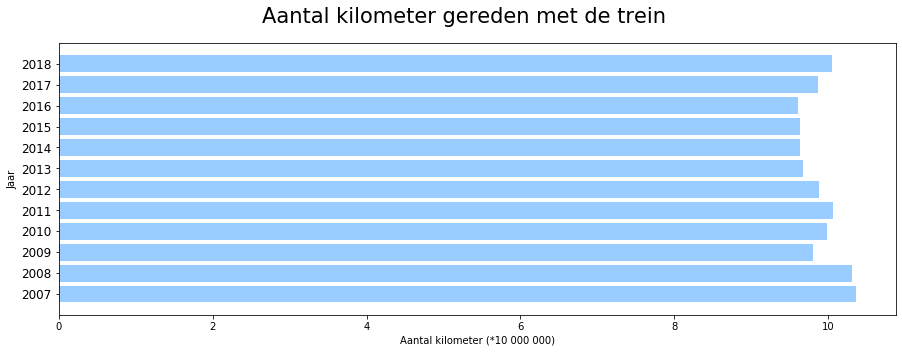

In [9]:
def get_totals(year):
    total = 0
    for line in items:
        if int(line[0]) == year:
            var = line[1]
            total += float(var)
    return (total/10000000)

years = [x for x in range(2007, 2019)]
aantal_kms = []

for x in range(2007, 2019):
    aantal_kms.append(get_totals(x))

fig = plt.figure(figsize=(15, 5))
plt1 = fig.add_subplot(111)
fig.suptitle('Aantal kilometer gereden met de trein', fontsize=21)
plt1.set_xlabel('Aantal kilometer (*10 000 000)')
plt1.set_ylabel('Jaar')
plt1.barh(years, aantal_kms, align='center', color='#99ccff')
#Set the x axis tick labels
plt.yticks(years, years, fontsize=12)
plt.show()

In [10]:
from IPython.display import HTML

form = """
<div style='background-color:lightgray; border:solid black; width:300px; padding:20px;'>
Jaar: <input id='hour' type='range' min='2007' max='2018' step='1' value='2012' onchange='set_vars()'/>
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_vars(){
        var var_name1 = 'inp_year';
        var var_value1 = document.getElementById('hour').value;
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        cell = IPython.notebook.get_cell(8);
        cell.execute();
        cell.focus_cell(8);
    }
</script>
"""

HTML(form + javascript)

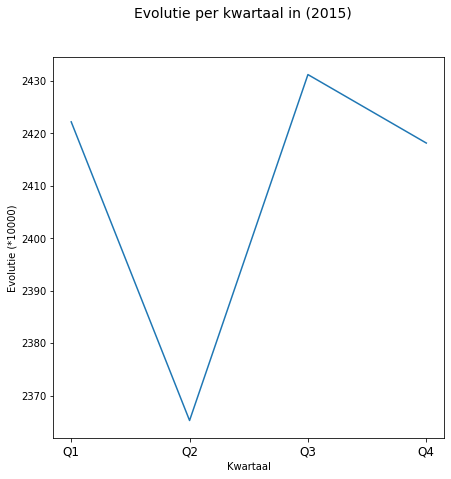

In [11]:
#grafiek van de evolutie per maand
%matplotlib inline
import matplotlib.pyplot as plt

QUARTERS = ['Q1', 'Q2', 'Q3', 'Q4']
items = []
for i in evolution_data.value:
    items.append([evolution_data.value[i][1], evolution_data.value[i][3]])

def get_totals(year):
    total = 0
    for line in items:
        if line[0] == year:
            var = line[1]
            total += float(var)
    return total/10000

x_axis = [i+1 for i in range(0,4)]
y_axis = []

for i in range(0,4):
    y_axis.append(get_totals(inp_year+ " - " + QUARTERS[i]))
  
    
fig1 = plt.figure(figsize=(7, 7))
fig1.suptitle('Evolutie per kwartaal in (' + inp_year + ')', fontsize=14)
ax = fig1.add_subplot(111)
ax.set_xlabel('Kwartaal')
ax.set_ylabel('Evolutie (*10000)')

#Set the x axis tick labels
plt.xticks(x_axis, QUARTERS ,fontsize = 12)
plt.plot(x_axis, y_axis)
plt.show()


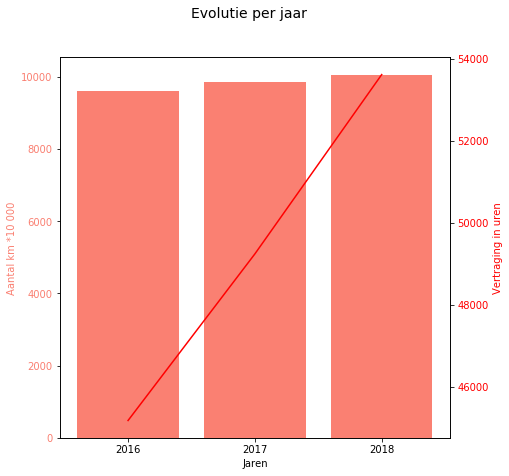

In [12]:
#per jaar dan een grafiekje met de twee datasets maken waar de twee satasets inzitte
vertraging = []
evolution = []
items = []
for i in evolution_data.value:
    items.append([evolution_data.value[i][0], evolution_data.value[i][3]])

def get_totals(year):
    total = 0
    for line in items:
        if int(line[0]) == year:
            var = line[1]
            total += float(var)
    return round(total, 2)/10000

for i in range (1, 4):
    evolution.append(get_totals(2015 + i))
    year = 2015 + i
    som = 0
    for i in range(1,13):
        var = str(year) + '-' + str(i).zfill(2)
        som = som + (float(train_data.value[var][1].replace(',','.')))
    vertraging.append(som/60)   

x_axis = [1, 2, 3]

fig1 = plt.figure(figsize=(7, 7))
fig1.suptitle('Evolutie per jaar', fontsize=14)
ax = fig1.add_subplot(111)
ax.set_xlabel('Jaren')
ax.bar(x_axis, evolution, align='center', color='salmon')

#Set the x axis tick labels
plt.xticks(x_axis, YEARS)
ax.set_ylabel("Aantal km *10 000", color="salmon")
ax.tick_params(axis='y', labelcolor="salmon") 

ax2 = ax.twinx()
ax2.set_ylabel("Vertraging in uren", color="red")
ax2.tick_params(axis='y', labelcolor="red")
ax2.plot(x_axis, vertraging, color="red")

plt.show()

In [3]:
import pygame
from pygame.locals import *

pygame.init()
pygame.display.set_caption('End credits')
screen = pygame.display.set_mode((800, 600))
screen_r = screen.get_rect()
font = pygame.font.SysFont("comic sans", 40)
clock = pygame.time.Clock()

def main():

    credit_list = ["CREDITS"," ","Karen Veraa","Ruben Mampaey","Christoper Jacobs", "Tibo Depovere", "","Support", "Philippe Possemiers", "","Catering", "Frituur Kevertje"]

    texts = []
    # we render the text once, since it's easier to work with surfaces
    # also, font rendering is a performance killer
    for i, line in enumerate(credit_list):
        s = font.render(line, 1, (10, 10, 10))
        # we also create a Rect for each Surface. 
        # whenever you use rects with surfaces, it may be a good idea to use sprites instead
        # we give each rect the correct starting position 
        r = s.get_rect(centerx=screen_r.centerx, y=screen_r.bottom + i * 45)
        texts.append((r, s))    
    while True:
        for e in pygame.event.get():
            if e.type == QUIT or e.type == KEYDOWN and e.key == pygame.K_ESCAPE:
                return

        screen.fill((194, 176, 120))
        
        for r, s in texts:
            # now we just move each rect by one pixel each frame
            r.move_ip(0, -1)
            # and drawing is as simple as this
            screen.blit(s, r)

        # if all rects have left the screen, we exit
        if not screen_r.collidelistall([r for (r, _) in texts]):
            return

        # only call this once so the screen does not flicker
        pygame.display.flip()

        # cap framerate at 60 FPS
        clock.tick(60)

if __name__ == '__main__': 
    main()